# Authors: Anastasiia Karpova; William Liaw

# IMA204 Practical Session - Segmentation of medical images



In [1]:
# For listing files in local foler
import glob
import os
import operator

# For Kmeans
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.morphology as morpho
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from scipy import ndimage

# For loading .mat files
from scipy.io import loadmat
from skimage import color, data, morphology, segmentation
from skimage.filters import gaussian, rank
from skimage.io import imread
from skimage.measure import find_contours
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.util import img_as_ubyte

Working_directory = os.getcwd()
print("Working_directory = ", Working_directory)

Working_directory =  c:\Users\willf\OneDrive\Telecom\2023-2024\IMA204\TP\TP4


In [2]:
def my_kmeans(image, k):
    # k = number of clusters

    # Reshaping the image
    pixel_vals = image.reshape((-1, 1))

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
        100,
        0.85,
    )  # criteria
    retval, labels, centers = cv2.kmeans(
        pixel_vals, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS
    )
    centers = np.uint8(centers)  # convert data into 8-bit values

    segmented_data = centers[
        labels.flatten()
    ]  # Mapping labels to center points( RGB Value)
    segmented_image = segmented_data.reshape(
        (image.shape)
    )  # reshape data into the original image dimensions

    segmented_labels = labels  # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape(
        (image.shape)
    )  # reshape data into the original image dimensions

    return segmented_image, segmented_labels


def my_colormap_white_bkg(Colormap_name, numLabels):
    # numLabels = number of colors

    Colormap = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256 / 256, 256 / 256, 256 / 256, 1])
    max_color = np.array([0 / 256, 0 / 256, 0 / 256, 1])
    newcolors[numLabels - 1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

# Answers

## First use case

In [3]:
def crop_center(img, new_shape):
    start = tuple(map(lambda a, da: a // 2 - da // 2, img.shape, new_shape))
    end = tuple(map(operator.add, start, new_shape))
    slices = tuple(map(slice, start, end))

    return img[slices]

In [4]:
def segment_brain_pipeline(
    Img_brain,
    resize_shape,
    center_shape,
    equalize_adapthist_clip_limit,
    median_filter_size,
    initial_lower_bound,
    Target_value_thresh,
    nber_clusters,
    objects_min_size,
    verbose=0,
):
    # Preprocessing ========================================

    # Simple thresholding
    Img_brain[Img_brain < 255 * initial_lower_bound] = 0

    # Reshaping the brain: resampling and croping to the center
    original_shape = Img_brain.shape
    Img_brain = cv2.resize(Img_brain, resize_shape)
    Img_brain = crop_center(Img_brain, center_shape)

    # Histogram equalization and median filtering
    img_histeqmed = (
        ndimage.median_filter(
            skimage.exposure.equalize_adapthist(
                Img_brain, clip_limit=equalize_adapthist_clip_limit
            ),
            size=median_filter_size,
        )
        * 255
    ).astype("uint8")

    # Segmentation ========================================

    # Segmentation via simple thresholding: used to define target calss
    Seg_thresh = morphology.opening(
        morphology.remove_small_holes(
            morphology.remove_small_objects(
                img_histeqmed > Target_value_thresh * 255, min_size=500, connectivity=1
            ),
            area_threshold=500,
        ),
        morphology.disk(3),
    ).astype("uint8")

    # Segmentation via kmeans: used to identify different classes
    Seg_km, Seg_km_labels = my_kmeans(img_histeqmed, nber_clusters)

    if verbose >= 1:
        Colormap = plt.get_cmap("nipy_spectral", nber_clusters)

        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        ax = axes.ravel()

        ax[0].imshow(Img_brain, cmap="gray")
        ax[0].set_title("Original")

        ax[1].imshow(img_histeqmed, cmap="gray")
        ax[1].set_title("HistEqMed")

        ax[2].imshow(Seg_thresh, cmap="gray")
        ax[2].set_title("Thresholding")

        tmp = ax[3].imshow(Seg_km, cmap="nipy_spectral")
        divider = make_axes_locatable(ax[3])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ax[3].set_title("kmeans Centers")
        fig.colorbar(tmp, cax=cax, orientation="vertical")

        tmp = ax[4].imshow(Seg_km_labels, cmap=Colormap)
        divider = make_axes_locatable(ax[4])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(tmp, cax=cax, orientation="vertical")
        ax[4].set_title("kmeans labels")

        fig.tight_layout()
        plt.show()

    # Post processing ========================================

    # Get mean pixel intensity values under all Kmeans labels
    Img_label_means = np.empty(nber_clusters)
    for i in range(0, nber_clusters):
        Img_label_mask = Seg_km_labels == i
        Img_label_mask = Img_label_mask.astype("uint8")
        tmp = cv2.mean(img_histeqmed, Img_label_mask)
        Img_label_means[i] = tmp[0]

    # Set a target intensity value (derived from the thresholding segmentation)
    # and get the Kmeans label closest to it
    Target_value = cv2.mean(img_histeqmed, Seg_thresh)
    Target_value = Target_value[0]
    Diff = np.absolute(Img_label_means - Target_value * np.ones(nber_clusters))
    Label_select = np.argmin(Diff)

    if verbose >= 1:
        print("Your Target_value = ", np.round(Target_value).astype(int))
        print("Distance of your Target_value to Centers = ", np.round(Diff).astype(int))
        print("Your selected label (starting with 0) = ", Label_select)

    # Filter the selected label and get a binary segmentation mask
    Img_label_select = Seg_km_labels == Label_select

    # Removing small objects and small holes
    Img_label_select_clean = morphology.remove_small_holes(
        morphology.remove_small_objects(
            Img_label_select, min_size=objects_min_size, connectivity=1
        ),
        area_threshold=objects_min_size,
    )

    if verbose >= 1:
        fig, axes = plt.subplots(1, 2, figsize=(6, 5))
        ax = axes.ravel()

        ax[0].imshow(Img_label_select, cmap="gray")
        ax[1].imshow(Img_label_select_clean, cmap="gray")

        plt.show()

    # Selecting largest contour
    _, labels, stats, _ = cv2.connectedComponentsWithStats(
        Img_label_select_clean.astype("uint8"), connectivity=4
    )
    final_mask = (255 * (labels == np.argsort(stats[:, 4])[-2])).astype("uint8")

    # Restoring original shape
    final_mask = np.pad(
        final_mask,
        (
            (
                (resize_shape[0] - Img_brain.shape[0]) // 2,
                (resize_shape[0] - Img_brain.shape[0]) // 2,
            ),
            (
                (resize_shape[1] - Img_brain.shape[1]) // 2,
                (resize_shape[1] - Img_brain.shape[1]) // 2,
            ),
        ),
        mode="constant",
        constant_values=0,
    )
    final_mask = cv2.resize(final_mask, original_shape)
    final_mask[final_mask > 0] = 255

    return final_mask

Variables defined:

- `index`: Index to select brain image (used values: $0$ to $3$)
- `brainMRI_path`: Path to the brain images directory (used value across all cases `Working_directory + "/data/brainMRI"`, `Working_directory` as previously defined)
- `Img_seg_gt`: Segmented image ground truth (used values derived from `index`)
- `Img_brain`: Selected brain image (used values derived from `index`)
- `resize_shape`: Shape to resize on the spatial normalization preprocessing(used value across all cases `(256, 256)`)
- `center_shape`: Center shape to crop on the spatial normalization preprocessing (used value across all cases `(140, 100)`). As the corpus callosum is generally located around the center of the image, this preprocessing is specially useful for this use case.
- `equalize_adapthist_clip_limit`: Clipping limit on histogram equalization preprocessing (used value across all cases `0.04`)
- `median_filter_size`: Median filter size on preprocessing (used value across all cases `4`)
- `initial_lower_bound`: Threshold on preprocessing (used value across all cases `0.1`)
- `Target_value_thresh`: Threshold on threshold segmentation(used value across all cases `0.6`)
- `nber_clusters`: Number of clusters on Kmeans segmentation (used value across all cases `5`)
- `objects_min_size`: The smallest allowable object size on removal of objects and holes post processing (used value across all cases `150`)

Brain index: 0 ================================================================================


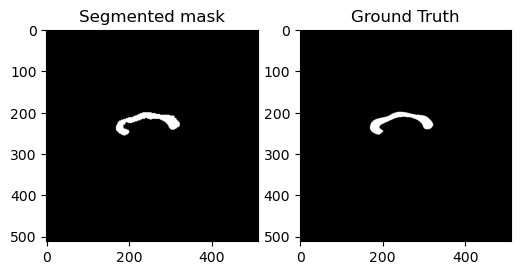

Dice: 0.8899208806329549



Brain index: 1 ================================================================================


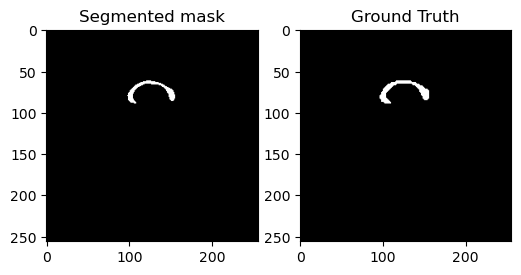

Dice: 0.8147295742232451



Brain index: 2 ================================================================================


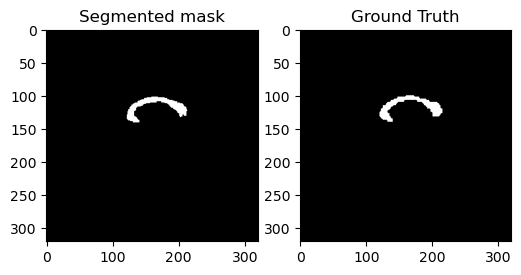

Dice: 0.816542014958205



Brain index: 3 ================================================================================


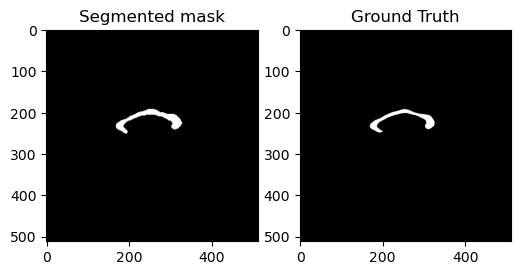

Dice: 0.8647488192357234





In [5]:
for index in range(4):
    print(
        f"Brain index: {index} ================================================================================"
    )

    # Reading the brain image and its mask
    brainMRI_path = Working_directory + "/data/brainMRI"
    listImagesbrainMRI = glob.glob(brainMRI_path + "/*-seg.png")

    filename_seg = listImagesbrainMRI[index]
    Img_seg_gt = imread(filename_seg)

    filename = filename_seg[:-8] + ".png"
    Img_brain = imread(filename)

    mask = segment_brain_pipeline(
        Img_brain=Img_brain,
        resize_shape=(256, 256),
        center_shape=(140, 100),
        equalize_adapthist_clip_limit=0.04,
        median_filter_size=4,
        initial_lower_bound=0.1,
        Target_value_thresh=0.6,
        nber_clusters=5,
        objects_min_size=150,
    )

    # visualizations
    fig, axes = plt.subplots(1, 2, figsize=(6, 5))
    ax = axes.ravel()

    ax[0].imshow(mask, cmap="gray")
    ax[0].set_title("Segmented mask")
    ax[1].imshow(Img_seg_gt, cmap="gray")
    ax[1].set_title("Ground Truth")

    mask = mask // 255
    Img_seg_gt = Img_seg_gt // 255

    plt.show()

    Dice = (
        np.sum(np.logical_and(mask, Img_seg_gt))
        * 2.0
        / (np.sum(mask) + np.sum(Img_seg_gt))
    )

    print(f"Dice: {Dice}")
    print("\n\n")

In the context of brain imagery, a comprehensive pipeline was successfully developed for all images, consistently producing segmented masks of the corpus callosum. The implementation, utilizing identical hyperparameters across cases, achieved a Dice coefficient surpassing $80%$. Upon qualitative analysis of the original brain images, it is evident that the segmented masks align well with the structures present, reinforcing the reliability of the segmentation process.

## Second use case

### Functions for assessing the quality of segmentation

In [6]:
def compute_dice_coefficient(mask_true, mask_pred):
    """
    The function calculates the Dice coefficient between two binary masks:
    the true mask and the predicted mask.

    Dice coefficient measures the similarity between masks.
    The value ranges from 0 to 1, where 1 means a perfect match of the masks.

    Parameters:
    - mask_true: a binary mask representing the true region of interest.
    - mask_pred: a binary mask representing the predicted region of interest.

    Returns:
    - Dice coefficient
    """
    intersection = np.logical_and(mask_true, mask_pred)
    dice_coefficient = (2.0 * intersection.sum()) / (mask_true.sum() + mask_pred.sum())
    return dice_coefficient

def compute_iou(mask_true, mask_pred):
    """
    The function calculates the Jaccard coefficient (Intersection over Union) between two binary masks:
    the true mask and the predicted mask.

    The value ranges from 0 to 1, where 1 means a perfect match of the masks.

    Parameters:
    - mask_true: a binary mask representing the true region of interest.
    - mask_pred: a binary mask representing the predicted region of interest.

    Returns:
    - Jaccard coefficient
    """
    intersection = np.logical_and(mask_true, mask_pred)
    union = np.logical_or(mask_true, mask_pred)
    iou = intersection.sum() / union.sum()
    return iou

### Segmentation for kidney

In [7]:
def segment_brain_pipeline(
    Img_abdo_ex,
    equalize_adapthist_clip_limit,
    median_filter_size,
    initial_lower_bound,
    Target_value_thresh,
    nber_clusters,
    objects_min_size,
    verbose=0,
):
    # Preprocessing ========================================

    # Simple thresholding
    Img_abdo_ex[Img_abdo_ex < 255 * initial_lower_bound] = 0

    # Histogram equalization and median filtering
    img_histeqmed = (
        ndimage.median_filter(
            skimage.exposure.equalize_adapthist(
                Img_abdo_ex, clip_limit=equalize_adapthist_clip_limit
            ),
            size=median_filter_size,
        )
        * 255
    ).astype("uint8")

    # Segmentation ========================================

    # Segmentation via simple thresholding: used to define target calss
    Seg_thresh = morphology.opening(
        morphology.remove_small_holes(
            morphology.remove_small_objects(
                Img_abdo_ex > Target_value_thresh * 255, min_size=500, connectivity=1
            ),
            area_threshold=500,
        ),
        morphology.disk(3),
    ).astype("uint8")

    # Segmentation via kmeans: used to identify different classes
    Seg_km, Seg_km_labels = my_kmeans(img_histeqmed, nber_clusters)

    if verbose >= 1:
        Colormap = plt.get_cmap("nipy_spectral", nber_clusters)

        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        ax = axes.ravel()

        ax[0].imshow(Img_abdo_ex, cmap="gray")
        ax[0].set_title("Original")

        ax[1].imshow(img_histeqmed, cmap="gray")
        ax[1].set_title("HistEqMed")

        ax[2].imshow(Seg_thresh, cmap="gray")
        ax[2].set_title("Thresholding")

        tmp = ax[3].imshow(Seg_km, cmap="nipy_spectral")
        divider = make_axes_locatable(ax[3])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ax[3].set_title("kmeans Centers")
        fig.colorbar(tmp, cax=cax, orientation="vertical")

        tmp = ax[4].imshow(Seg_km_labels, cmap=Colormap)
        divider = make_axes_locatable(ax[4])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(tmp, cax=cax, orientation="vertical")
        ax[4].set_title("kmeans labels")

        fig.tight_layout()
        plt.show()

    # Post processing ========================================

    # Get mean pixel intensity values under all Kmeans labels
    Img_label_means = np.empty(nber_clusters)
    for i in range(0, nber_clusters):
        Img_label_mask = Seg_km_labels == i
        Img_label_mask = Img_label_mask.astype("uint8")
        tmp = cv2.mean(img_histeqmed, Img_label_mask)
        Img_label_means[i] = tmp[0]

    # Set a target intensity value (derived from the thresholding segmentation)
    # and get the Kmeans label closest to it
    Target_value = cv2.mean(img_histeqmed, Seg_thresh)
    Target_value = Target_value[0]
    Diff = np.absolute(Img_label_means - Target_value * np.ones(nber_clusters))
    Label_select = np.argmin(Diff)

    if verbose >= 1:
        print("Your Target_value = ", np.round(Target_value).astype(int))
        print("Distance of your Target_value to Centers = ", np.round(Diff).astype(int))
        print("Your selected label (starting with 0) = ", Label_select)

    # Filter the selected label and get a binary segmentation mask
    Img_label_select = Seg_km_labels == Label_select

    # Removing small objects and small holes
    Img_label_select_smooth_clean = morphology.remove_small_holes(
        morphology.remove_small_objects(
            Img_label_select, min_size=objects_min_size, connectivity=1
        ),
        area_threshold=objects_min_size,
    )

    if verbose >= 1:
        fig, axes = plt.subplots(1, 2, figsize=(6, 5))
        ax = axes.ravel()

        ax[0].imshow(Img_label_select, cmap="gray")
        ax[1].imshow(Img_label_select_smooth_clean, cmap="gray")

        plt.show()

    # Selecting largest contour
    numlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    Img_label_select_smooth_clean.astype(np.uint8), connectivity=8
    )

    matrix = np.column_stack((range(numlabels), stats[:, 4]))
    sorted_matrix = sorted(matrix, key=lambda row: row[1], reverse=True)

    final_mask = (255 * ((labels == sorted_matrix[1][0]) | (labels == sorted_matrix[2][0]))).astype("uint8")
    final_mask = morphology.binary_erosion(morphology.binary_dilation(final_mask/255, disk(7)), disk(2))

    return final_mask

Variables defined:

- `images_for_segmentation`: a list of indexes of abdominal CT scans intended for segmentation
- `indexIm`: Index to select abdominal CT scan (used values: $3$ to $5$)
- `num_iterations` - number of iterations, how many times we train the model
- `abdominalCT_path`: Path to the abdominal CT scans directory (used value across all cases `Working_directory + "/data/abdominalCT"`, `Working_directory` as previously defined)
- `Img_seg`: Segmented image of a kidney ground truth (used values derived from `indexIm`)
- `Img_abdo_ex`: Selected abdominal CT scan (used values derived from `indexIm`)
- `equalize_adapthist_clip_limit`: Clipping limit on histogram equalization preprocessing (used value across all cases `0.04`)
- `median_filter_size`: Median filter size on preprocessing (used value across all cases `4`)
- `initial_lower_bound`: Threshold on preprocessing (used value across all cases `0.1`)
- `Target_value_thresh`: Threshold on threshold segmentation(used value across all cases `0.57`)
- `nber_clusters`: Number of clusters on Kmeans segmentation (used value across all cases `10`)
- `objects_min_size`: The smallest allowable object size on removal of objects and holes post processing (used value across all cases `150`)

Iteration: 1 ================================================================================
Abdominal CT scan index: 3 ================================================================================


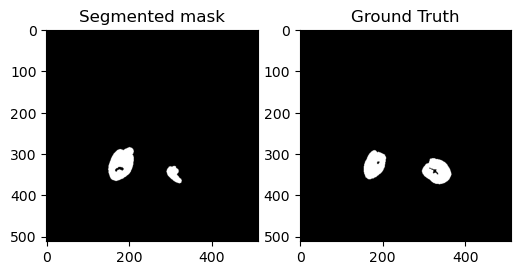

Dice Coefficient: 0.640443968454873
IoU (Jaccard Index): 0.47106846175880834



Abdominal CT scan index: 4 ================================================================================


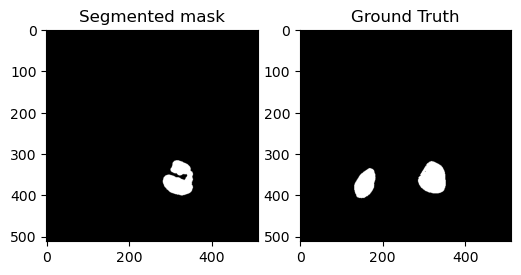

Dice Coefficient: 0.651154097747874
IoU (Jaccard Index): 0.48274906470832757



Abdominal CT scan index: 5 ================================================================================


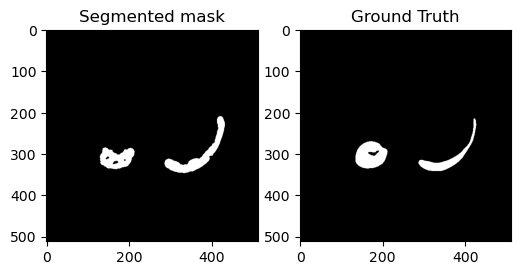

Dice Coefficient: 0.7635801560429855
IoU (Jaccard Index): 0.617573520657221



Iteration: 2 ================================================================================
Abdominal CT scan index: 3 ================================================================================


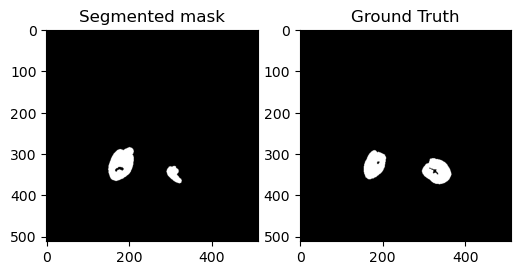

Dice Coefficient: 0.640443968454873
IoU (Jaccard Index): 0.47106846175880834



Abdominal CT scan index: 4 ================================================================================


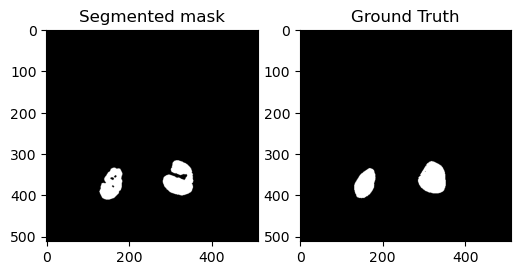

Dice Coefficient: 0.8687463213655091
IoU (Jaccard Index): 0.7679500520291364



Abdominal CT scan index: 5 ================================================================================


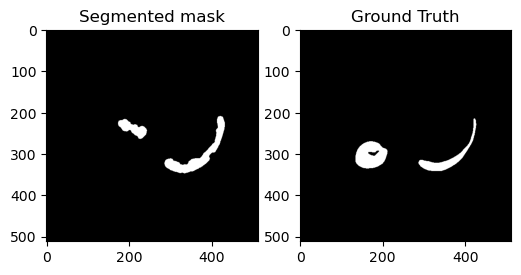

Dice Coefficient: 0.4214553149926746
IoU (Jaccard Index): 0.2669897906569042





In [8]:
images_for_segmentation = [3, 4, 5]
num_iterations = 2

for i in range(num_iterations):
    print(
        f"Iteration: {i+1} ================================================================================"
    )

    for indexIm in images_for_segmentation:
        print(
            f"Abdominal CT scan index: {indexIm} ================================================================================"
        )

        # Reading the Abdominal CT scan and mask for kidney
        abdominalCT_path = Working_directory + "/data/abdominalCT"
        os.listdir(abdominalCT_path)
        listImagesabdCT = glob.glob(abdominalCT_path + "/*-seg.tiff")

        filename_Segmentation = listImagesabdCT[indexIm]
        Labels_abdo_ex = imread(filename_Segmentation)

        filename = filename_Segmentation[:-9] + ".tiff"
        Img_abdo_ex = imread(filename)

        if Img_abdo_ex.shape != Labels_abdo_ex.shape:
            raise NameError("image and mask should have the same shape, problem...")

        Seg_abdo_kidney_ex = Labels_abdo_ex == 127
        Img_seg = Seg_abdo_kidney_ex

        mask = segment_brain_pipeline(
            Img_abdo_ex=Img_abdo_ex,
            equalize_adapthist_clip_limit=0.04,
            median_filter_size=4,
            initial_lower_bound=0.1,
            Target_value_thresh=0.57,
            nber_clusters=10,
            objects_min_size=150,
        )

        # visualizations
        fig, axes = plt.subplots(1, 2, figsize=(6, 5))
        ax = axes.ravel()

        ax[0].imshow(mask / 255, cmap="gray")
        ax[0].set_title("Segmented mask")
        ax[1].imshow(Img_seg, cmap="gray")
        ax[1].set_title("Ground Truth")

        plt.show()

        dice_coefficient = compute_dice_coefficient(Img_seg, mask)
        iou = compute_iou(Img_seg, mask)

        print(f"Dice Coefficient: {dice_coefficient}")
        print(f"IoU (Jaccard Index): {iou}")

        print("\n\n")

In the cases discussed above, the kidneys are segmented using three different abdominal CT scans. We can notice that the regions of interest to us consist of two connected components. Using the final masks, we can determine the location of the areas of interest to us on the scans and, in some cases, almost completely determine the shape. In cases 3, we manage to segment well only one of the connected components, and in case 4 and 5 we get a good result for both components. 

To assess the quality of segmentation, the Dice and Jaccard coefficients were used. For the Dice coefficient we always get a value greater than 0.6 and for the Jaccard coefficient values close to 0.5